In [25]:

import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
import joblib
import requests
from tqdm import tqdm_notebook as tqdm
from pytorch_lightning import seed_everything
import random
import warnings 
warnings.filterwarnings('ignore')
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# config

In [26]:
batch_size = 32
hidden_size = 128
state_size = 6
request_size = 2
value_size = 2
action_size = 9
time_step = 144

In [27]:
# Load data
data = joblib.load('..\data\dataset.pkl')

#for i in ['state','action','value']:
#    data[i] = np.vstack([data[i],data[i],data[i],data[i]])

a = pd.DataFrame(data['value']).describe()
display(a)

data['request'] = np.hstack([
    np.random.uniform(low=a.loc['50%'][0],high=a.loc['75%'][0],size=(365,1)),
    np.random.uniform(low=a.loc['50%'][1],high=a.loc['75%'][1],size=(365,1))])

b = pd.DataFrame(data['request']).describe()
display(b)



# shape
print(data['state'].shape)
print(data['action'].shape)
print(data['value'].shape)
print(data['request'].shape)

# tensor
data['state'] = torch.FloatTensor(data['state'])
data['request'] = torch.FloatTensor(data['request'])
data['action'] = torch.FloatTensor(data['action'])
data['value'] = torch.FloatTensor(data['value'])



# data_iter
data = TensorDataset(data['state'],data['request'],data['action'],data['value'])
train_iter = DataLoader(data,batch_size=batch_size,shuffle=True)

,0,1
count,365.000000,365.000000
mean,0.829624,0.577700
std,0.138448,0.117761
min,0.000000,0.000000
25%,0.827393,0.515305
50%,0.867552,0.605195
75%,0.897141,0.655521
max,1.000000,1.000000


,0,1
count,365.000000,365.000000
mean,0.882096,0.630088
std,0.008612,0.015130
min,0.867702,0.605741
25%,0.874708,0.615913
50%,0.882682,0.629961
75%,0.889122,0.643518
max,0.896846,0.655506


(365, 144, 6)
(365, 144, 9)
(365, 2)
(365, 2)


# R2D2 MODEL

In [28]:

class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx


# ActorCritic Model

In [29]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    
    self.actor = actor
    self.actor_optimizer = MADGRAD(actor.parameters() ,lr = 1e-3)
    
    self.critic = critic
    self.critic_optimizer = MADGRAD(critic.parameters() ,lr = 1e-3)
  
  def forward(self,state,request):
    actions = self.actor_forward(state,request)
    values = self.critic_forward(state,actions)
    return values

  def actor_forward(self,state,request,eval=False):
    '''
    # 給定狀態(不可控)和需求 輸出一系列動作
    '''
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    
    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()
    
    # 對一定時間長度進行遍歷
    for t in range(self.time_step):
      # 在t時刻 根據t時刻的狀態,需求以及短期記憶hx,長期記憶cx當作輸入,得到輸出a(動作),更新後的短期記憶hx,更新後的長期記憶cx
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    # 一系列動作 (Batch,Time,Features)
    actions = actions.reshape(state.size()[0],self.time_step,-1)
    
    return actions
  
  def critic_forward(self,state,action,eval=False):
    '''
    # 輸入狀態(不可控)和一系列動作(可控),預測產出
    '''

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()
    
    # 對時間點遍歷
    for t in range(self.time_step):
      # 根據當前t時刻狀態,動作,hx,cx當輸入得到,v(產出),更新hx,cx
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)
    
    # 一系列產出(Batch,Time,Features)
    values = values.reshape(state.size()[0],self.time_step,-1)
    
    # 只取最後一個時間點
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)
    
    # 預測值跟label的平方差愈小愈好
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最小化產出跟request的差異'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)

    # 首先預測值跟需求的平方差愈小愈好
    loss1 = ((request-value_hat)**2).mean()

    # 再來避免"變異數太大(時間維度上)" 因為盤控人員不可能突然調太多
    loss2 = actions.reshape(-1,time_step,action_size).std(axis=1)
    loss2 = loss2.sum(axis=-1).mean(axis=0)

    loss = loss1 + loss2
    loss.backward()
    
    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [30]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
critic = R2D2(state_size+action_size,value_size,hidden_size)
model = ActorCritic(actor,critic,time_step)

# train loop

In [31]:
def train_critic():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_critic(bs,ba,bv)
  return loss

def train_actor():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_actor(bs,br)
  return loss

def train(model,train_iter,epochs=100):
  train_history = {}
  train_history['actor'] = []
  train_history['critic'] = []
  
  for epoch in tqdm(range(epochs)):
    loss = train_critic()
    train_history['critic'].append(loss)
    if epoch % 10 == 0:
      print('epoch:{} critic_loss:{}'.format(epoch,loss))
    
  for epoch in tqdm(range(epochs)):
    loss = train_actor()
    train_history['actor'].append(loss)
    if epoch % 10 == 0:
      print('epoch:{} actor_loss:{}'.format(epoch,loss))
    
  return model,train_history

In [32]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)
print(actions.shape)
pd.DataFrame(actions[0].detach().numpy()).head().style.background_gradient()

torch.Size([32, 144, 9])


,0,1,2,3,4,5,6,7,8
0,0.502087,0.508360,0.504921,0.503552,0.511091,0.513761,0.481228,0.478758,0.482656
1,0.504408,0.509899,0.499908,0.499602,0.513644,0.516361,0.479550,0.473755,0.481492
2,0.505750,0.510417,0.497384,0.497409,0.514844,0.517728,0.478855,0.470724,0.480735
3,0.506573,0.510504,0.496099,0.496178,0.515483,0.518477,0.478779,0.469010,0.480363
4,0.507087,0.510437,0.495432,0.495467,0.515859,0.518887,0.478985,0.468081,0.480216


In [33]:
model,train_history = train(model,train_iter,epochs=100)

epoch:0 critic_loss:0.7081844247877598
epoch:10 critic_loss:0.16732210107147694
epoch:20 critic_loss:0.15505659859627485
epoch:30 critic_loss:0.14008885901421309
epoch:40 critic_loss:0.12184087885543704
epoch:50 critic_loss:0.1425082739442587
epoch:60 critic_loss:0.1539016435854137
epoch:70 critic_loss:0.12009873706847429
epoch:80 critic_loss:0.13196248398162425
epoch:90 critic_loss:0.11454021884128451



epoch:0 actor_loss:0.0897389529272914
epoch:10 actor_loss:0.05045960796996951
epoch:20 actor_loss:0.041664703749120235
epoch:30 actor_loss:0.031054766150191426
epoch:40 actor_loss:0.018824824946932495
epoch:50 actor_loss:0.015328253386542201
epoch:60 actor_loss:0.01368354627629742
epoch:70 actor_loss:0.012410937459208071
epoch:80 actor_loss:0.012038174842018634
epoch:90 actor_loss:0.012507387436926365



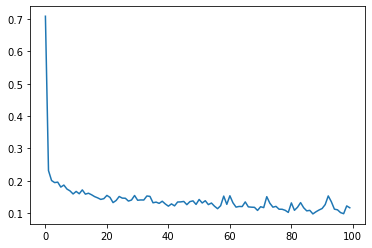

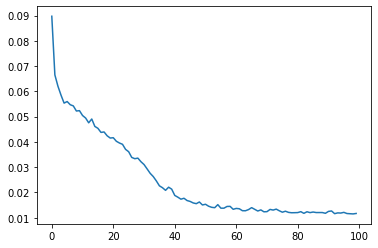

In [34]:
import matplotlib.pyplot as plt

plt.plot(train_history['critic'])
plt.show()
plt.plot(train_history['actor'])

In [35]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)

In [36]:
pd.DataFrame(actions[0].detach().numpy()).head().style.background_gradient()

,0,1,2,3,4,5,6,7,8
0,0.218480,0.422462,0.817281,0.337685,0.489751,0.799388,0.579703,0.377988,0.462319
1,0.218557,0.422256,0.817377,0.337740,0.489733,0.799227,0.579990,0.377908,0.462192
2,0.218613,0.422194,0.817368,0.337794,0.489732,0.799130,0.580099,0.377877,0.462138
3,0.218675,0.422174,0.817345,0.337824,0.489731,0.799045,0.580138,0.377870,0.462112
4,0.218669,0.422156,0.817370,0.337821,0.489732,0.799046,0.580163,0.377861,0.462100


In [37]:
values = model.critic_forward(s[[0]],actions[[0]],eval=True)
values

tensor([[0.8655, 0.6669]], grad_fn=<SliceBackward>)

# 令廠商想要控制某種產出率為[0.897141,0.655521],其中state(s)不可控,則用法為

In [59]:
wanna_ouput = [0.897141,0.655521]
s,r,a,v = next(iter(train_iter))
s = s[0].reshape(-1,time_step,state_size)
r = torch.hstack([torch.full((1,1),wanna_ouput[0]),torch.full((1,1),wanna_ouput[1])])
a = model.actor_forward(s,r,eval=True)
v = model.critic_forward(s,a,eval=True)

In [60]:
# 模型建議操作
pd.DataFrame(a[0].detach().numpy()).head().style.background_gradient()

,0,1,2,3,4,5,6,7,8
0,0.216718,0.423050,0.819023,0.337127,0.490277,0.801245,0.580023,0.377743,0.462437
1,0.216786,0.422898,0.819134,0.337234,0.490223,0.801079,0.580229,0.377784,0.462365
2,0.216779,0.422844,0.819149,0.337260,0.490178,0.801028,0.580332,0.377746,0.462334
3,0.216816,0.422834,0.819137,0.337285,0.490159,0.800958,0.580363,0.377728,0.462321
4,0.216805,0.422823,0.819164,0.337284,0.490158,0.800959,0.580381,0.377716,0.462312


In [61]:
# 模型預測根據上述操作應當的產出
print(f'value:{v.detach().numpy()}\n')

value:[[0.89189094 0.6418217 ]]



In [62]:
# save weight
torch.save(model.actor.state_dict(),'../model/actor.pth')
torch.save(model.critic.state_dict(),'../model/critic.pth')